# Corrector Coil

Here we will make a corrector coil as a 3D Cartesian grid and track.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.constants import c

from pmd_beamphysics.fields.corrector_modeling import make_dipole_corrector_fieldmesh 

from impact import Impact

# Create FieldMesh

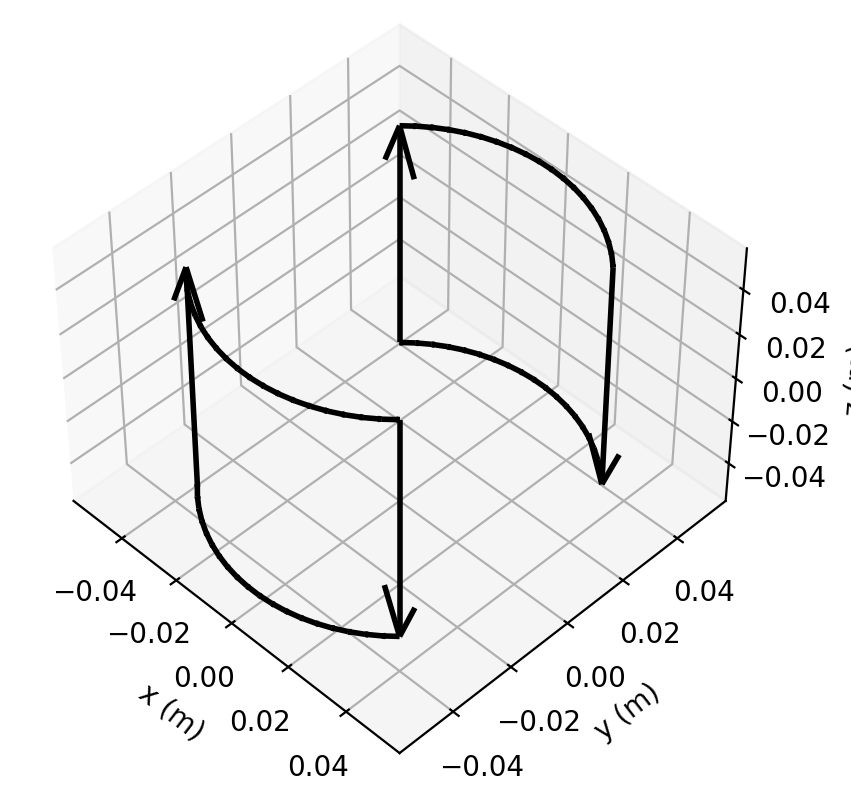

In [3]:
R = 2*2.54e-2      # 2" radius [m]
L = 0.1            # Length along z [m]
theta = np.pi/2    # Opening angle [rad]
current=100          # Current [Amp]

FM = make_dipole_corrector_fieldmesh(current=current,
                                     xmin=-R, xmax=R, nx=21,
                                     ymin=-R, ymax=R, ny=21,
                                     zmin=-5*L/2, zmax=5*L/2, nz=101,
                                     mode='saddle',
                                     R=R, L=L, theta=theta, npts=20, 
                                     plot_wire=True)

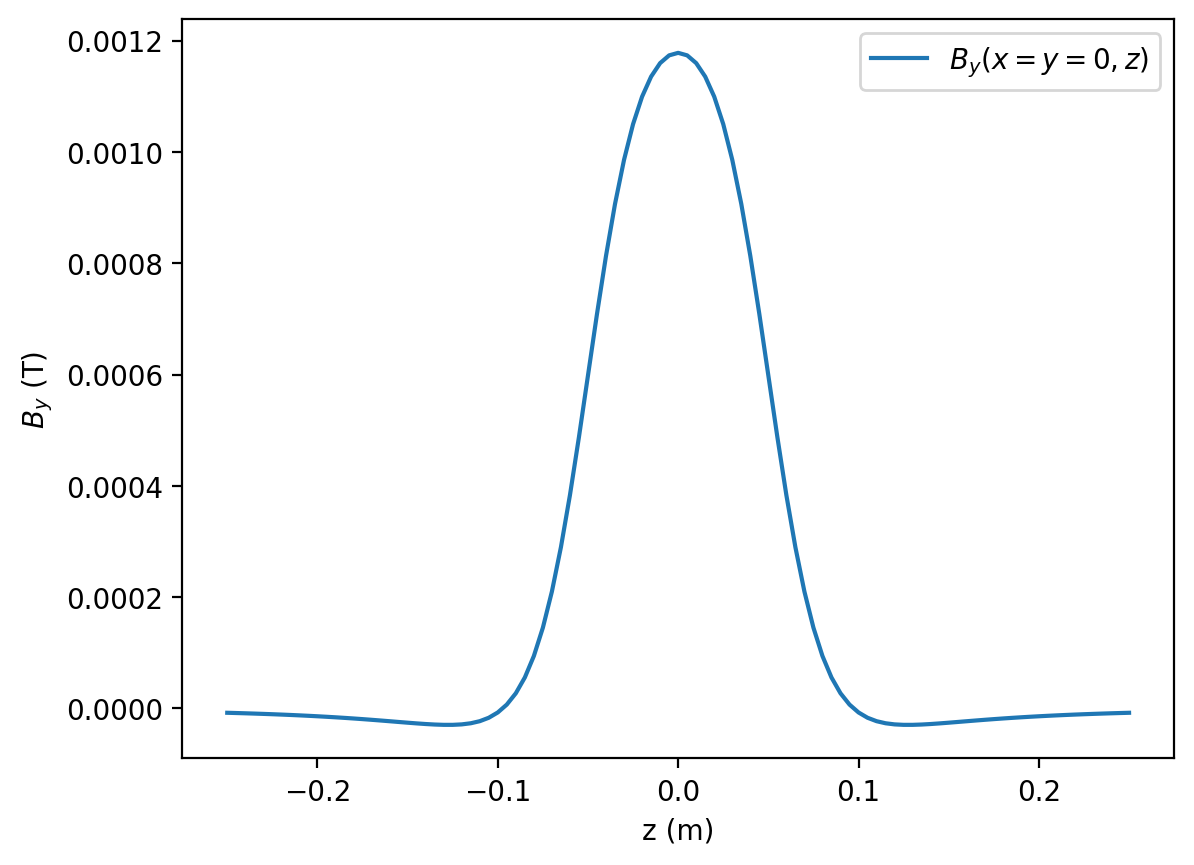

In [4]:
FM.plot_onaxis('By')

In [5]:
FM.write_impact_emfield_cartesian('1T1.T7')

FM.write('correctorcoil.h5')

In [6]:
!head '1T1.T7'

-0.0508 0.050800000000000026 20
-0.0508 0.050800000000000026 20
-0.25 0.25000000000000044 100
(0.0,0.0) (0.0,0.0) (0.0,0.0) (7.266778003195628e-07,0.0) (-6.684101581996645e-06,0.0) (3.83229347012872e-06,0.0)
(0.0,0.0) (0.0,0.0) (0.0,0.0) (6.629550990941515e-07,0.0) (-6.745260435430512e-06,0.0) (3.889753814666732e-06,0.0)
(0.0,0.0) (0.0,0.0) (0.0,0.0) (5.964885880319834e-07,0.0) (-6.800725076236698e-06,0.0) (3.941974118895811e-06,0.0)
(0.0,0.0) (0.0,0.0) (0.0,0.0) (5.275369437597234e-07,0.0) (-6.85025692629636e-06,0.0) (3.988687567442801e-06,0.0)
(0.0,0.0) (0.0,0.0) (0.0,0.0) (4.5637604272089085e-07,0.0) (-6.893640106321602e-06,0.0) (4.029656677871314e-06,0.0)
(0.0,0.0) (0.0,0.0) (0.0,0.0) (3.832963658326224e-07,0.0) (-6.930683372942628e-06,0.0) (4.064674477636792e-06,0.0)
(0.0,0.0) (0.0,0.0) (0.0,0.0) (3.086004791829832e-07,0.0) (-6.961221848559757e-06,0.0) (4.093565285140309e-06,0.0)


In [7]:
!ls -ahl

total 26280
drwxr-xr-x  10 chrisonian  staff   320B Oct 17 14:12 .
drwxr-xr-x  20 chrisonian  staff   640B Oct 15 18:12 ..
drwxr-xr-x   7 chrisonian  staff   224B Oct 15 18:49 .ipynb_checkpoints
-rw-r--r--   1 chrisonian  staff   4.9M Oct 17 14:12 1T1.T7
-rw-r--r--   1 chrisonian  staff   741B Oct 15 18:11 ImpactT.in
-rw-r--r--   1 chrisonian  staff   314K Oct 17 14:07 bmad_to_impact.ipynb
-rw-r--r--   1 chrisonian  staff   463K Oct 17 13:59 corrector_coil.ipynb
-rw-r--r--   1 chrisonian  staff   2.0M Oct 17 14:12 correctorcoil.h5
-rw-r--r--   1 chrisonian  staff   551B Oct 17 14:12 lat.bmad
-rw-r--r--   1 chrisonian  staff   4.1M Oct 17 14:01 lat.bmad.digested323


# Prepare Impact-T

In [8]:
I = Impact('ImpactT.in')
I.ele['COIL']#['rf_field_scale'] = 1

{'description': 'name:COIL',
 'original': '0.5 0 0 111 0.0 1 0.0 0 1 0.02 0.0 0.0 0.0 0.0 0.0 /!name:COIL',
 'L': 0.5,
 'type': 'emfield_cartesian',
 'zedge': 0.0,
 'rf_field_scale': 1.0,
 'rf_frequency': 0.0,
 'theta0_deg': 0.0,
 'filename': '1T1.T7',
 'radius': 0.02,
 's': 0.5,
 'name': 'COIL'}

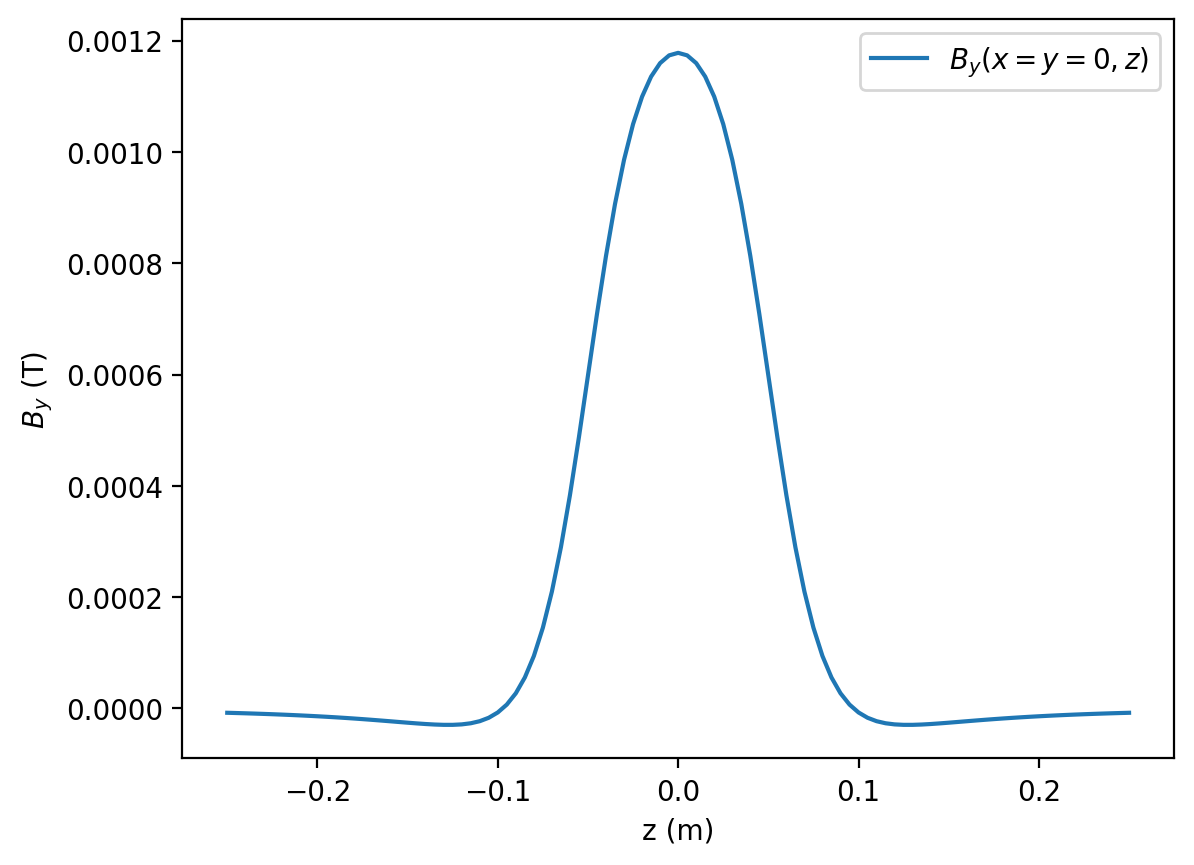

In [9]:
FM = I.fieldmaps['1T1.T7']['field']
FM.plot_onaxis('By')

In [10]:
I.ele['COIL']

{'description': 'name:COIL',
 'original': '0.5 0 0 111 0.0 1 0.0 0 1 0.02 0.0 0.0 0.0 0.0 0.0 /!name:COIL',
 'L': 0.5,
 'type': 'emfield_cartesian',
 'zedge': 0.0,
 'rf_field_scale': 1.0,
 'rf_frequency': 0.0,
 'theta0_deg': 0.0,
 'filename': '1T1.T7',
 'radius': 0.02,
 's': 0.5,
 'name': 'COIL'}

# Check field integral

In [11]:
z0 = FM.coord_vec('z')
By0 = np.real(FM.By[FM.shape[0]//2, FM.shape[1]//2, :]) 

BL = np.trapezoid(By0, z0)
pz0=10e6

theta0 = BL*c/pz0

theta0

np.float64(0.0034032888133728695)

In [12]:
BL

np.float64(0.00011352149537307137)

In [13]:
I.track1(pz0=pz0)
theta1 = I.particles['final_particles'].px/pz0

theta1

array([0.00340284])

In [14]:
theta1/theta0 -1

array([-0.00013244])

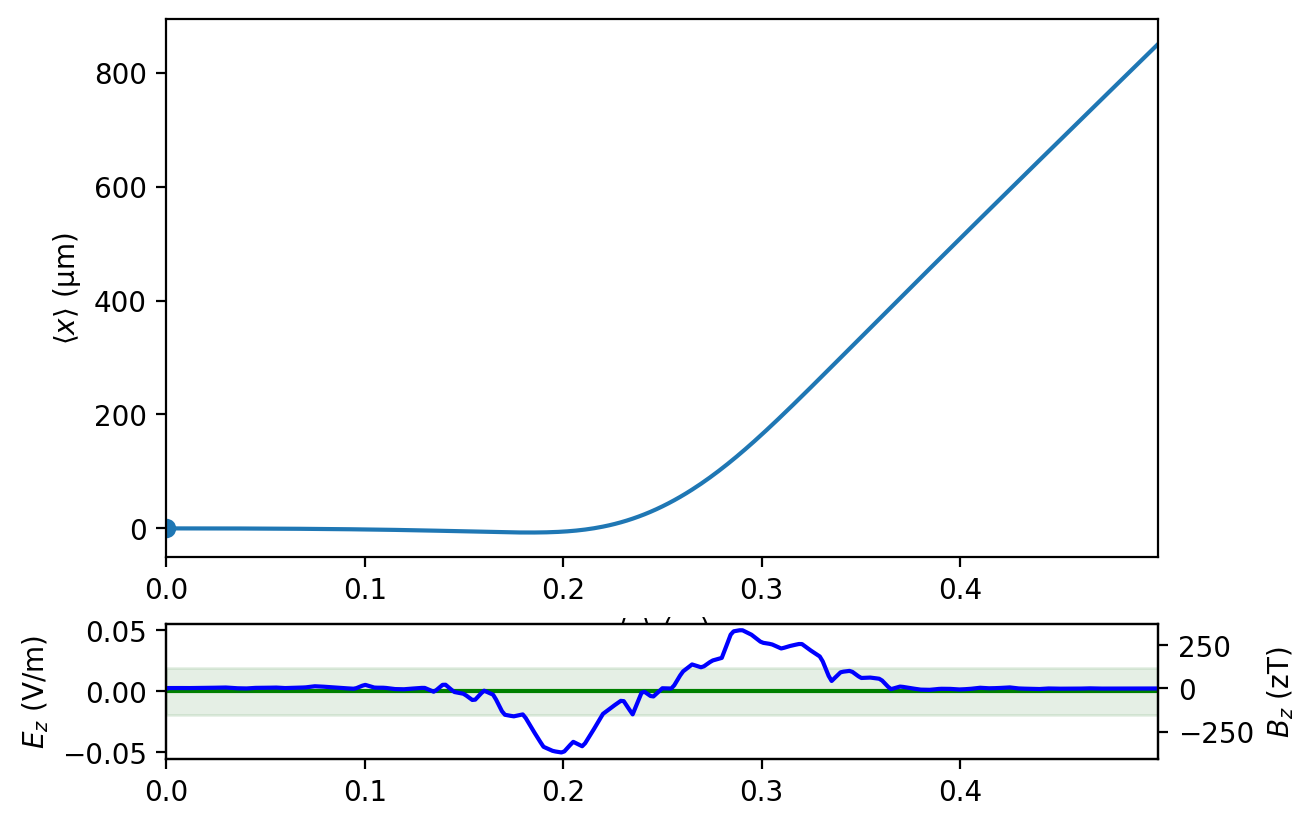

In [15]:
I.plot('mean_x')

In [16]:
I.fieldmaps['1T1.T7']

{'info': {'format': 'emfield_cartesian_fieldmesh'},
 'field': <FieldMesh with rectangular geometry and (21, 21, 101) shape at 0x147923a40>}